# Packed Padded Sequences, Masking, Inference and BLEU
- 강좌: 텍스트 및 자연어 빅데이터 분석 방법론
- 작성: 성지훈
- 발표일: 21.11.04(목) 
<br><br><br>

**오늘 할 일**
1. Packed Padded Sequences & Masking이 어떻게 Neural Machine Translation에 사용되는지
2. Inference는 무엇이고, 그 기능과 사용법은 무엇인지
3. BLEU는 무엇이고, 그 기능과 사용법은 무엇인지

# 1. Packed Padded Sequences and Masking
선행자료: [3-Neural Machine Translation](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)

<br>
- 이전 모델에서 있었던 compression문제를 해결하기 위해서 decoder에게 각 decoding step에서 src sentence를 참고하는 것을 허용함
> using attention!

## 1.1 Packed Padded Sequences
- 기능: 인코딩에서 RNN 할 때 패딩 토큰을 건너 뛰라고 말해줌
- Padded?
    - batch에 들어가는 src 길이가 달라지기 때문에 padding을 넣어서 길이를 맞춰줌
- Packed?
    - padding으로 인해 생기는 불필요한 계산을 방지하기 위해서 각 time step의 batch size를 알려주는 것


## 1.2 Masking
- 기능: 모델이 특정 값을 무시하도록 함
- 앞선 padding이 수행되면, attention vector에 불필요한 값이 생기게됨 
- 그 원소들을 0으로 변환해줌

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random
import math
import time, os
from sys import platform

print('Current OS : ', platform)
print('Pytorch Ver : ', torch.__version__)
print('TorchText Ver : ', torchtext.__version__)

Current OS :  win32
Pytorch Ver :  1.8.1
TorchText Ver :  0.9.1


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
# BATCH_SIZE = 128
BATCH_SIZE = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu')) #### 차이1
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) ##### 차이2
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

- Calculating Energy
    - previous decoder hidden state와 encoder hidden state의 'match'를 봄

In [10]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10) #### 차이3
        
        return F.softmax(attention, dim = 1)

- Decoder에서 context vector를 구성하는 방법에서 본 페이퍼와 달리 deviation을 줬음
- 본 페이퍼는 first backward RNN hidden state만을 사용했으나,
- 여기서는 forward, backward RNN hidden state 모두 사용

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        '''변화를 준 부분''' 
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask) #### 차이4. 
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src) #### 차이5. 

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

In [13]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [14]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [16]:
optimizer = optim.Adam(model.parameters())

In [17]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 11m 47s
	Train Loss: 3.649 | Train PPL:  38.443
	 Val. Loss: 3.384 |  Val. PPL:  29.496
Epoch: 02 | Time: 11m 39s
	Train Loss: 2.588 | Train PPL:  13.309
	 Val. Loss: 3.146 |  Val. PPL:  23.245
Epoch: 03 | Time: 11m 41s
	Train Loss: 2.165 | Train PPL:   8.717
	 Val. Loss: 3.212 |  Val. PPL:  24.833
Epoch: 04 | Time: 11m 33s
	Train Loss: 1.896 | Train PPL:   6.657
	 Val. Loss: 3.315 |  Val. PPL:  27.525
Epoch: 05 | Time: 15m 51s
	Train Loss: 1.724 | Train PPL:   5.608
	 Val. Loss: 3.354 |  Val. PPL:  28.612
Epoch: 06 | Time: 16m 6s
	Train Loss: 1.622 | Train PPL:   5.064
	 Val. Loss: 3.497 |  Val. PPL:  33.010
Epoch: 07 | Time: 15m 30s
	Train Loss: 1.553 | Train PPL:   4.727
	 Val. Loss: 3.548 |  Val. PPL:  34.735
Epoch: 08 | Time: 15m 31s
	Train Loss: 1.516 | Train PPL:   4.556
	 Val. Loss: 3.614 |  Val. PPL:  37.102
Epoch: 09 | Time: 15m 33s
	Train Loss: 1.487 | Train PPL:   4.423
	 Val. Loss: 3.672 |  Val. PPL:  39.336
Epoch: 10 | Time: 15m 49s
	Train Loss: 1.482 | 

- referenced jupyter notebook 기준으로는 training time이 약 60% 정도로 감소하는 것을 보였으나,
- 제가 돌린 환경에서는 시간이 거의 동일하게 나왔습니다

In [22]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.172 | Test PPL:  23.851 |


- 일반 NMT 성능
    - Test Loss: 3.151
    - Test PPL: 23.368

# 2. Inference(Searching)

- 기능1: 문장을 주고, 어떻게 번역하는지 확인
- 기능2: 번역할 때 어떤 단어에 주의집중했는지 시각화
<br><br>
---

<img src="https://lena-voita.github.io/resources/lectures/seq2seq/general/inference_formula-min.png" width="80%">

Now the main question is: how to find the argmax?
<br><br>
---
Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [23]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [24]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone') # 밝을 수록 높은 값을 의미함
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [25]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


In [26]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'dog', 'fighting', '.', '<eos>']


C:\Users\jhun1\AppData\Local\Temp/ipykernel_12744/4268658779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\jhun1\AppData\Local\Temp/ipykernel_12744/4268658779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


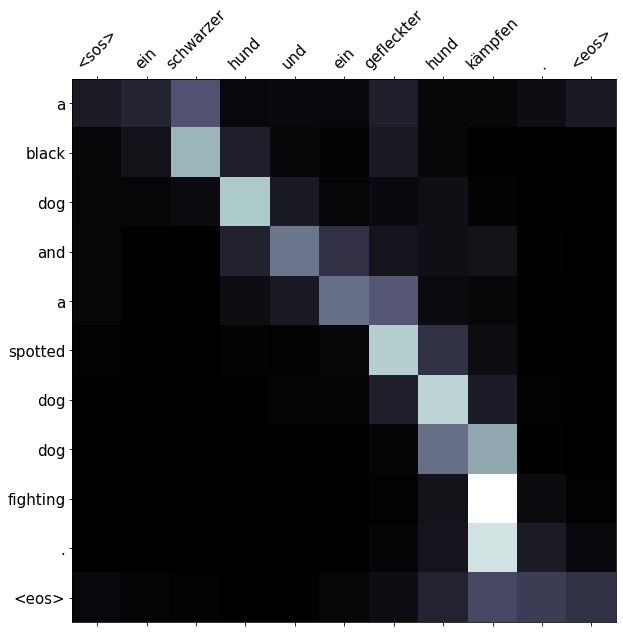

In [27]:
display_attention(src, translation, attention)

In [28]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


predicted trg = ['a', 'woman', 'playing', 'a', 'song', 'on', 'her', 'violin', '.', '<eos>']


C:\Users\jhun1\AppData\Local\Temp/ipykernel_12744/4268658779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\jhun1\AppData\Local\Temp/ipykernel_12744/4268658779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


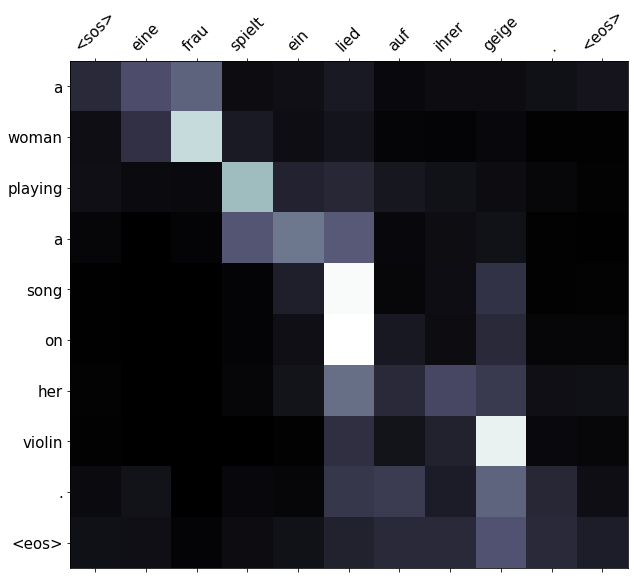

In [29]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [30]:

example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']
trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']


predicted trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '<eos>']


C:\Users\jhun1\AppData\Local\Temp/ipykernel_12744/4268658779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\jhun1\AppData\Local\Temp/ipykernel_12744/4268658779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


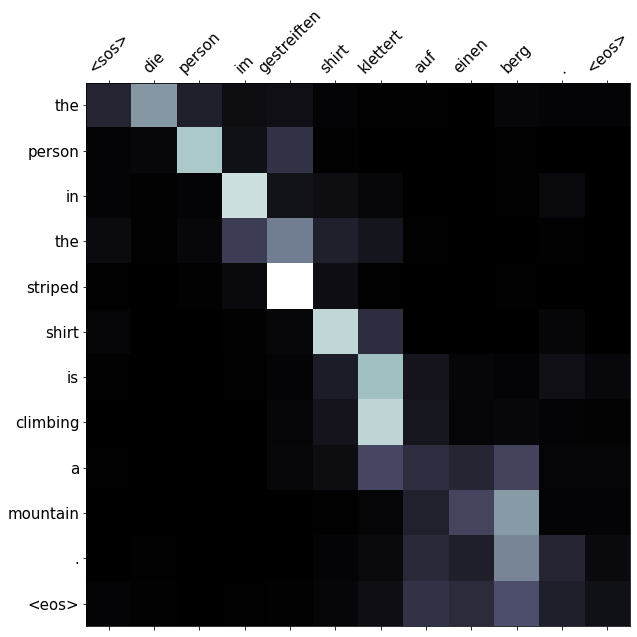

In [31]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

# 3. BLEU
- https://wikidocs.net/31695
- 의미: 번역의 품질을 평가하는 지표
- 번역 품질의 평가지표로서 Perplexity의 부적절성
    - 기본적으로 perplexity는 classification에 적합한 평가지표

## 3.1 Unigram Precision
단순하게 단어의 등장 횟수를 비교해서 번역 정확도를 보는 방법 

Candidate: 번역 결과 

Reference: 인간에게 번역시켜 얻은 정답라벨  
<br>
<br>
  
**Example1.** 
- Candidate1. It is a tutorial of NLP before entering Hugginface
- Candidate2. It is a guidance of NLP until using Hugginface
- Reference1. It is a tutorial of NLP before learning Huggingface
- Reference2. Before learning Huggingface, it is a tutorial of NLP
- Reference3. It's a beginning of NLP to using Huggingface 
<br>
<br>
직관적으로 단어의 등장 횟수만을 사용해 번역 품질을 평가하기  
<br>
<br>
$$ Unigram Precision = \frac{Ref들~중에서~존재하는~Ca의~단어의~수}{Ca의~총~단어~수} $$
<br>
<br>
- Candidate1: _entering_을 제외한 8개의 단어 모두 Ref1~3에 등장
$$Ca1~Unigram~Precision = \frac{8}{9}$$
- Candidate2: _guidance_, _until_ 을 제외한 7개의 단어 모두 Ref1~3에 등장
$$Ca2~Unigram~Precision = \frac{7}{9}$$


## 3.2 Modified Unigram Precision
What about...Candidate3?  
<br>
<br>
**Example2.** 
- Candidate1. It is a tutorial of NLP before entering Hugginface
- Candidate2. It is a guidance of NLP until using Hugginface
- `Candidate3.It It It It It It It` 
- Reference1. It is a tutorial of NLP before learning Huggingface
- Reference2. Before learning Huggingface, it is a tutorial of NLP
- Reference3. It's a beginning of NLP to using Huggingface 
<br>
<br>
- 3.1에서 정의한 방법에 따르면 Ca3의 유니그램 정밀도는 $\frac{7}{7}=1$이 됨 --> irrational!
- Max_Ref_Count 도입: 특정 유니그램이 하나의 Ref에 가장 많이 등장한 횟수
<br>
<br>
$$Count_{clip}=min(Count,Max~Ref~Count)$$
<br>
$$Modified~Unigram~Precision=\frac{Ca의~각~유니그램에~대해~Count_{clip}을~수행한~값의~총~합}{Ca의~총~유니그램~수}$$
<br><br>
- Ca3의 보정된 정밀도: $\frac{3}{7}$

## 3.3. N-gram Precision
유니그램 예제는 단어의 순서를 고려하지 못하는 한계 점이 있음
<br><br>
**Example3.** 
- Candidate1. It is a tutorial of NLP before entering Hugginface
- Candidate2. It is a guidance of NLP until using Hugginface
- `Candidate3.Hugginface using until NLP of tutorial a is it` 
- Reference1. It is a tutorial of NLP before learning Huggingface
- Reference2. Before learning Huggingface, it is a tutorial of NLP
- Reference3. It's a beginning of NLP to using Huggingface
<br><br>
- Ca1과 Ca3의 유니그램 정밀도는 같음 --> irrational!
- N-gram Precision 도입 필요
- in case of Bigram of Ca1..
|Bigram|Count|Count_{clip}|
|------|-----|-----|
|It is|2|1|
|is a |2|1|
|a tutorial|2|1|
|tutorial of|2|1|
|of NLP|3|1|
|NLP before|1|1|
|before entering|0|0|
|entering Hugginface|0|0|
|Sum|12|6|

<br><br>
- Ca1의 바이그램 정밀도: $\frac{6}{8}$
- Modified Unigram Precision generalized to Ngram Precision
$$p_{n}=\frac{\sum_{n-gram \in Candidate}Count_{clip}(n-gram)}{\sum_{n-gram \in Candidate}Count(n-gram)}$$
<br><br><br>

**BLEU(Bilingual Evaluation Understudy Score)** 
<br>
- 보정된 정밀도 $p_{1},~p_{2},~...$를 조합하여 사용
$$BLEU=exp(\sum_{n=1}^{N}w_{n}\log p_{n})$$
<br>
$p_{n}$: 각 n-gram의 보정된 정밀도 <br>
$N$: 최대 n-gram으로 일반적으로 4까지 함 <br>
$w_{n}$: 각 n-gram 별로 부여할 가중치

## 3.4 Brevity Penalty
3.3에서 정의한 BLEU 수식은 번역 문장의 길이가 짧을 때 대처할 수 없음
<br><br>
**Example4.** 
- Candidate1. It is a tutorial of NLP before entering Hugginface
- Candidate2. It is a guidance of NLP until using Hugginface
- `Candidate3.It is` 
- Reference1. It is a tutorial of NLP before learning Huggingface
- Reference2. Before learning Huggingface, it is a tutorial of NLP
- Reference3. It's a beginning of NLP to using Huggingface
<br><br><br>
- Ca3의 보정된 유니그램 정밀도는 $\frac{2}{2}$, 바이그램 정밀도는 $\frac{1}{1}$ --> irrational!
- Final function of BLEU: 
$$BLEU=BP \times \exp ({\sum_{n=1}^{N} w_{n}\log p_{n}})$$

\begin{equation}
 BP=
     \begin{cases}
         1 & \text{if c <r}\\
         \exp(1-{\frac{c}{r}}) & \text{if c \geq r}
     \end{cases}
\end{equation}


In [32]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [33]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 29.46
